In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from network import Model

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import json
from tools_lnd import rule_set_names
from task import rules_dict
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd

In [3]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig2','varimax')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [4]:
task_name_dict = {}
task_name_dict['Dly Anti'] = rule_set_names[5]
task_name_dict['RT Go'] = rule_set_names[1]
task_name_dict['Dly Go'] = rule_set_names[2]
task_name_dict['RT Anti'] = rule_set_names[4]
task_name_dict['Anti'] = rule_set_names[3]
task_name_dict['Go'] = rule_set_names[0]
task_name_dict['DNMS'] = rule_set_names[12]
task_name_dict['DMS'] = rule_set_names[11]
task_name_dict['DMC'] = rule_set_names[13]
task_name_dict['DNMC'] = rule_set_names[14]
task_name_dict['Dly DM 2'] = rule_set_names[7]
task_name_dict['Dly DM 1'] = rule_set_names[6]
task_name_dict['Ctx Dly DM 2'] = rule_set_names[9]
task_name_dict['Ctx Dly DM 1'] = rule_set_names[8]
task_name_dict['MultSen Dly DM'] = rule_set_names[10]

In [5]:
def varimax(Phi, gamma = 1.0, q = 100, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        print(i)
        if d_old!=0 and d/d_old < 1 + tol: break
    return R, dot(Phi, R)

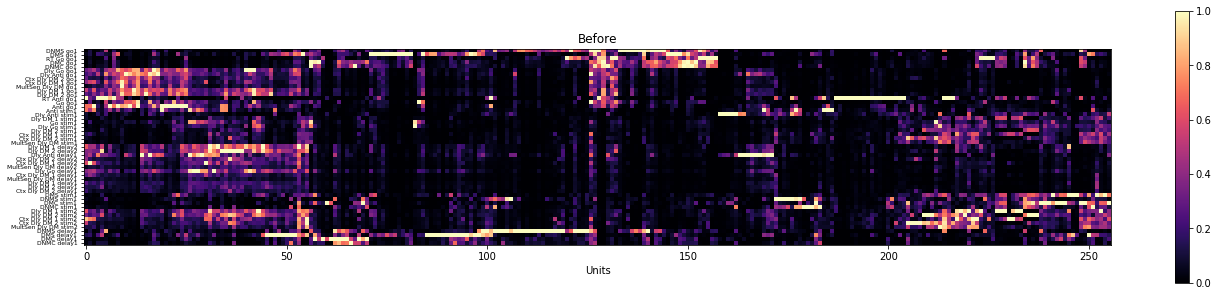

In [6]:
method = 'ward'
cel_max_d = 3.5
criterion = 'distance'
n_comps = 20

m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'
lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(cel_max_d)
save_dir = os.path.join(m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))

D = cluster_var['D'].T
feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]
components_set = {}

feature_names_master = ['DNMS go1', 'DMS go1', 'RT Go go1', 'DMC go1', 'DNMC go1',
       'Dly Go go1', 'Dly Anti go1', 'Ctx Dly DM 2 go1',
       'Ctx Dly DM 1 go1', 'MultSen Dly DM go1', 'Dly DM 1 go1',
       'Dly DM 2 go1', 'RT Anti go1', 'Go go1', 'Anti go1', 'Anti stim1',
       'Dly Anti stim1', 'Dly DM 1 stim1', 'Go stim1', 'Dly Go stim1',
       'Dly DM 2 stim1', 'Ctx Dly DM 1 stim1', 'Ctx Dly DM 2 stim1',
       'MultSen Dly DM stim1', 'Dly DM 1 delay2', 'Dly DM 2 delay2',
       'Dly Anti delay1', 'Ctx Dly DM 2 delay2', 'Ctx Dly DM 1 delay2',
       'MultSen Dly DM delay2', 'Dly Go delay1', 'Ctx Dly DM 1 delay1',
       'MultSen Dly DM delay1', 'Dly DM 1 delay1', 'Dly DM 2 delay1',
       'Ctx Dly DM 2 delay1', 'DMS stim1', 'DNMS stim1', 'DMC stim1',
       'DNMC stim1', 'Dly DM 1 stim2', 'Dly DM 2 stim2',
       'Ctx Dly DM 1 stim2', 'Ctx Dly DM 2 stim2', 'MultSen Dly DM stim2',
       'DNMS delay1', 'DMS delay1', 'DMC delay1', 'DNMC delay1']


feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
X = D[:,feat_order]
feature_names = feature_names_master

#SAVE original atlas
fig = plt.figure(figsize=(23, 5))
ax = plt.axes()
plt.imshow(X.T, cmap="magma")
plt.title('Before')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(list(feature_names),fontsize = 6)
plt.xlabel('Units')
plt.colorbar()

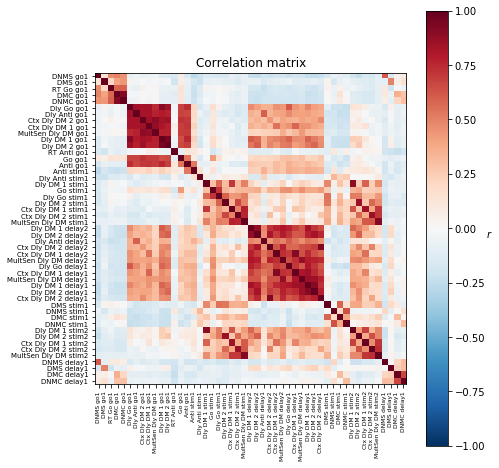

In [7]:
#Get corr before correlation
fig = plt.figure(figsize=(7, 7))
ax = plt.axes()
im = ax.imshow(np.corrcoef(X.T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(list(feature_names), rotation=90,fontsize = 6)
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(list(feature_names),fontsize = 7)
plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Correlation matrix")
plt.tight_layout()

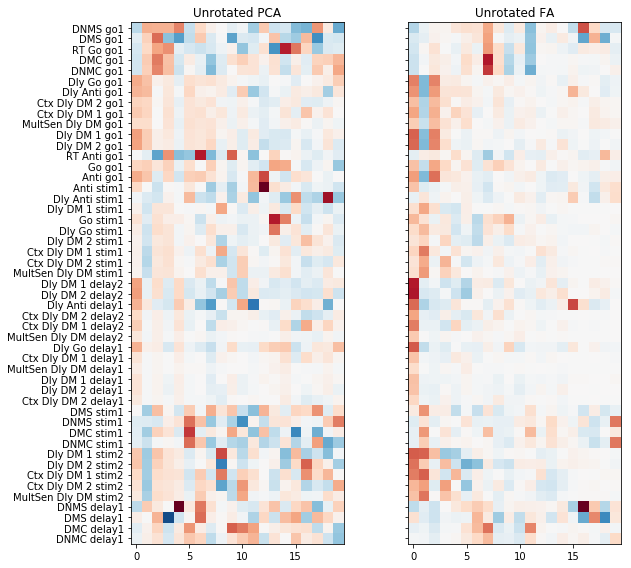

In [8]:
#Get unrotated factors
methods = [('Unrotated PCA', PCA()),
           ('Unrotated FA', FactorAnalysis())]

fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8))
for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X)
    components = fa.components_.T
    components_set[method] = components
    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
plt.tight_layout()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


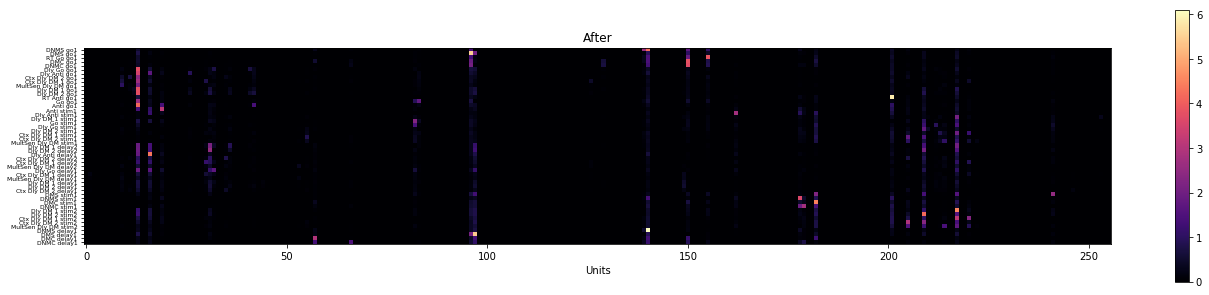

In [9]:
R, X_v = varimax(X.T)

#SAVE new atlas
fig = plt.figure(figsize=(23, 5))
ax = plt.axes()
plt.imshow(abs(X_v), cmap="magma")
plt.title('After')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(list(feature_names),fontsize = 6)
plt.xlabel('Units')
plt.colorbar()

In [29]:
np.argwhere(np.sum(X_v,axis = 0)>50)[0]

array([13])

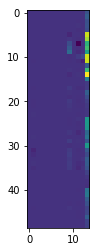

In [37]:
plt.imshow(X_v[:,:14])

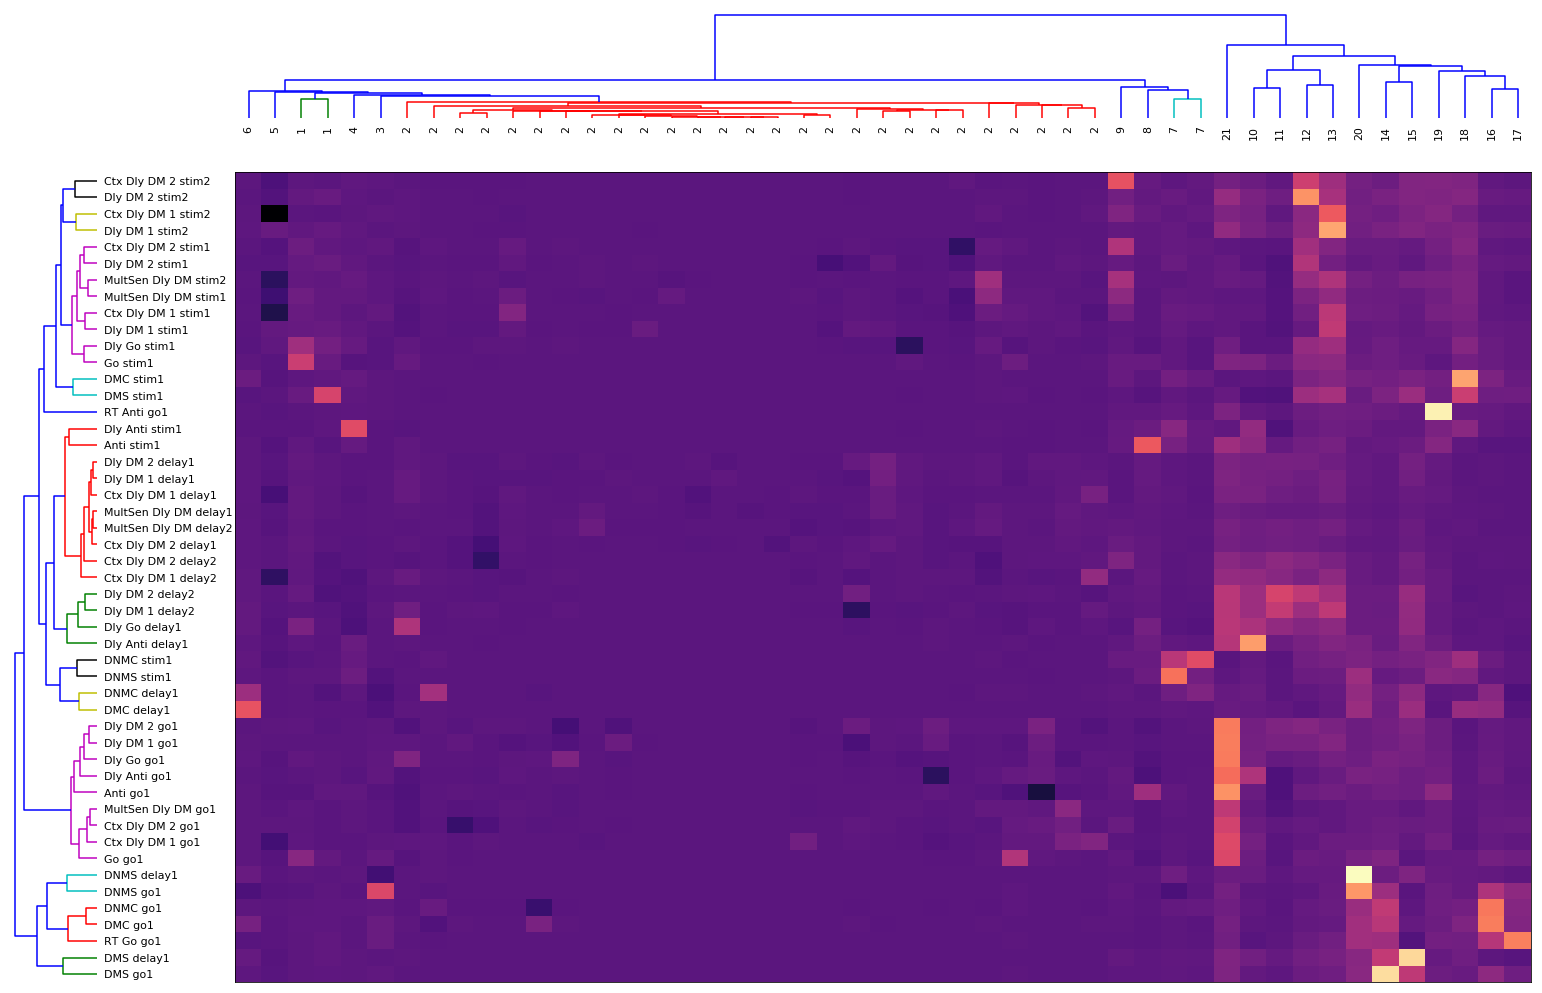

In [111]:
#SAVE new atlas rotated
import scipy
import pylab
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

method = 'ward'
cel_max_d = 3.5
criterion = 'distance'
n_comps = 20

sparse_inds = np.sum(abs(X_v),axis = 0)>1e-3
X_v = X_v[:,sparse_inds]

# Compute and plot dendrogram.
fig = pylab.figure(figsize=(24, 15))
axdendro = fig.add_axes([0.09,0.1,0.05,0.75])
Y = sch.linkage(X_v, method=method)

if criterion == 'maxclust':
    max_d = 14 #max number of task clusters
    clusters = fcluster(Y, max_d, criterion='maxclust') #CHANGE hard coded 14 clusters
else:
    max_d = 5 #threshold for task clusters
    clusters = fcluster(Y, max_d, criterion='distance')

Z = sch.dendrogram(Y, orientation='left',labels = feature_names_master,
                   leaf_font_size = 11,color_threshold=max_d)
axdendro.set_xticks([])
# axdendro.set_yticks([])
axdendro.spines['top'].set_visible(False)
axdendro.spines['right'].set_visible(False)
axdendro.spines['bottom'].set_visible(False)
axdendro.spines['left'].set_visible(False)

# Plot distance matrix.
axmatrix = fig.add_axes([0.22,0.1,0.75,0.75])
index_left = Z['leaves']
tick_names_sorted = [feature_names_master[i] for i in index_left]
X_v = X_v[index_left,:]

# cel_num = [CA.ind_active[x] for x in index_top]
axdendro_top = fig.add_axes([0.22,.9,0.75,0.1])
Y = sch.linkage(X_v.T, method=method)

if criterion== 'maxclust':
    clusters = fcluster(Y, cel_max_d, criterion='maxclust') #CHANGE hard coded 14 clusters
    Z = sch.dendrogram(Y, orientation='top',labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=0)

else:
    clusters = fcluster(Y, cel_max_d, criterion='distance')
    Z = sch.dendrogram(Y, orientation='top',labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=cel_max_d)

axdendro_top.set_yticks([])
axdendro_top.spines['top'].set_visible(False)
axdendro_top.spines['right'].set_visible(False)
axdendro_top.spines['bottom'].set_visible(False)
axdendro_top.spines['left'].set_visible(False)

index_top = Z['leaves']
X_v = X_v[:,index_top]
clusters_sorted = clusters[index_top]
im = axmatrix.matshow(X_v, aspect='auto', origin='lower',cmap='magma')
axmatrix.set_xticks([])
axmatrix.set_yticks([])
# fig.colorbar(im,orientation='horizontal')
plt.show()

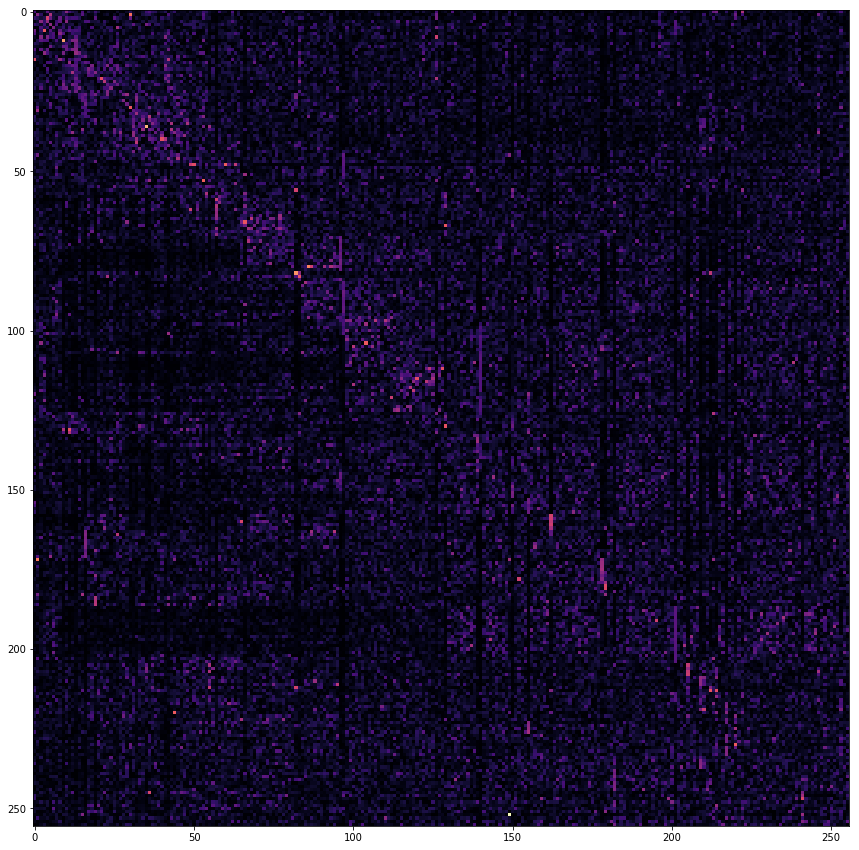

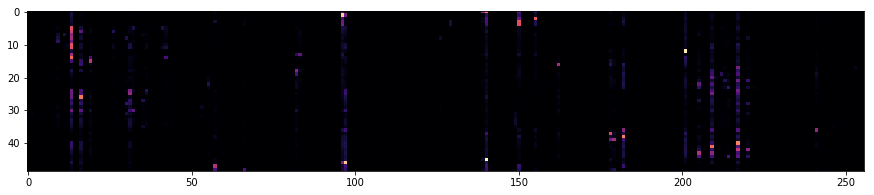

In [19]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
plt.imshow(abs(R), cmap="magma")
# plt.axis(False)
plt.show()

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111)
plt.imshow(abs(X_v), cmap="magma")
# plt.axes(False)
plt.show()
# plt.plot(R[:,13])

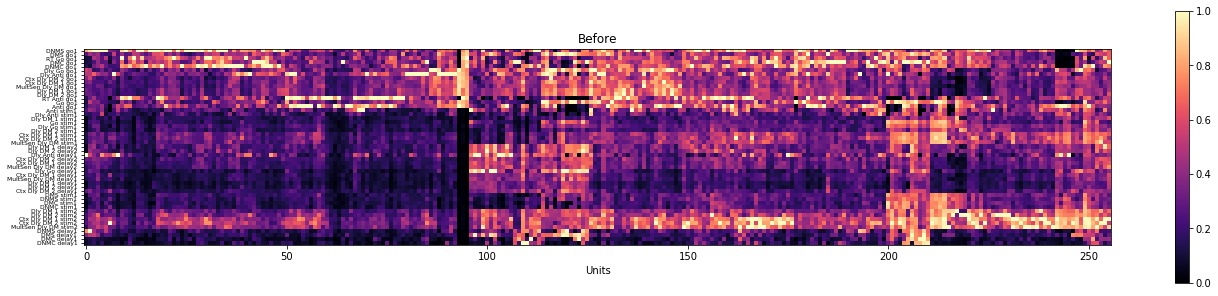

In [78]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0'
lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(cel_max_d)
save_dir = os.path.join(m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))

D = cluster_var['D'].T
feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]
components_set = {}

feature_names_master = ['DNMS go1', 'DMS go1', 'RT Go go1', 'DMC go1', 'DNMC go1',
       'Dly Go go1', 'Dly Anti go1', 'Ctx Dly DM 2 go1',
       'Ctx Dly DM 1 go1', 'MultSen Dly DM go1', 'Dly DM 1 go1',
       'Dly DM 2 go1', 'RT Anti go1', 'Go go1', 'Anti go1', 'Anti stim1',
       'Dly Anti stim1', 'Dly DM 1 stim1', 'Go stim1', 'Dly Go stim1',
       'Dly DM 2 stim1', 'Ctx Dly DM 1 stim1', 'Ctx Dly DM 2 stim1',
       'MultSen Dly DM stim1', 'Dly DM 1 delay2', 'Dly DM 2 delay2',
       'Dly Anti delay1', 'Ctx Dly DM 2 delay2', 'Ctx Dly DM 1 delay2',
       'MultSen Dly DM delay2', 'Dly Go delay1', 'Ctx Dly DM 1 delay1',
       'MultSen Dly DM delay1', 'Dly DM 1 delay1', 'Dly DM 2 delay1',
       'Ctx Dly DM 2 delay1', 'DMS stim1', 'DNMS stim1', 'DMC stim1',
       'DNMC stim1', 'Dly DM 1 stim2', 'Dly DM 2 stim2',
       'Ctx Dly DM 1 stim2', 'Ctx Dly DM 2 stim2', 'MultSen Dly DM stim2',
       'DNMS delay1', 'DMS delay1', 'DMC delay1', 'DNMC delay1']


feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
X = D[:,feat_order]
feature_names = feature_names_master

#SAVE original atlas
fig = plt.figure(figsize=(23, 5))
ax = plt.axes()
plt.imshow(X.T, cmap="magma")
plt.title('Before')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(list(feature_names),fontsize = 6)
plt.xlabel('Units')
plt.colorbar()

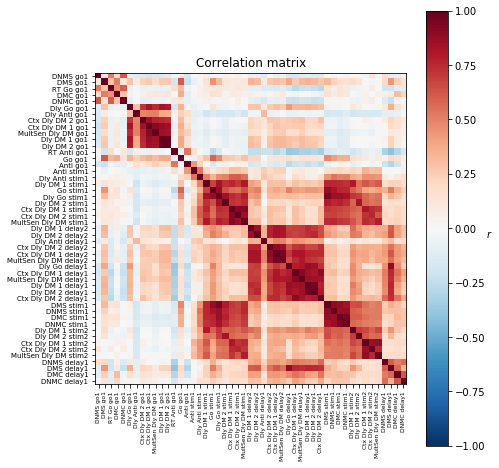

In [79]:
#Get corr before correlation
fig = plt.figure(figsize=(7, 7))
ax = plt.axes()
im = ax.imshow(np.corrcoef(X.T), cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(list(feature_names), rotation=90,fontsize = 6)
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(list(feature_names),fontsize = 7)
plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("Correlation matrix")
plt.tight_layout()

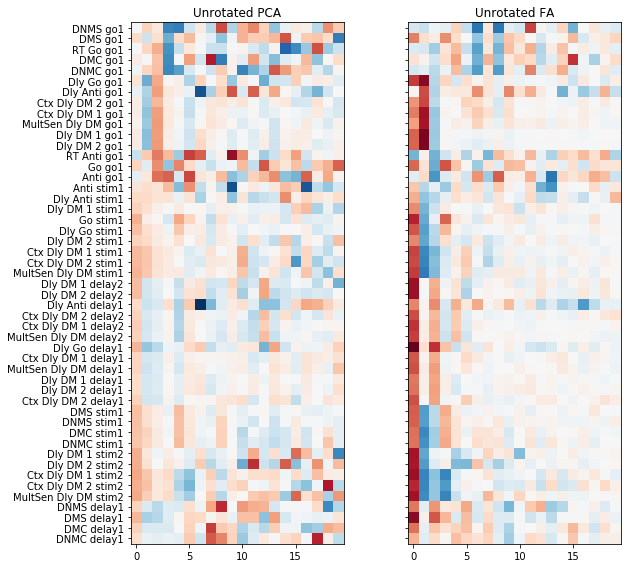

In [80]:
#Get unrotated factors
methods = [('Unrotated PCA', PCA()),
           ('Unrotated FA', FactorAnalysis())]

fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8))
for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X)
    components = fa.components_.T
    components_set[method] = components
    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
plt.tight_layout()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


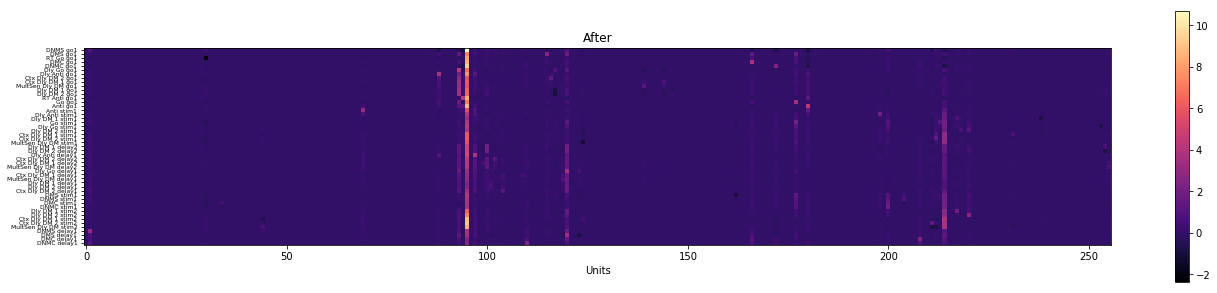

In [81]:
R, X_v = varimax(X.T)

#SAVE new atlas
fig = plt.figure(figsize=(23, 5))
ax = plt.axes()
plt.imshow(X_v, cmap="magma")
plt.title('After')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(list(feature_names),fontsize = 6)
plt.xlabel('Units')
plt.colorbar()

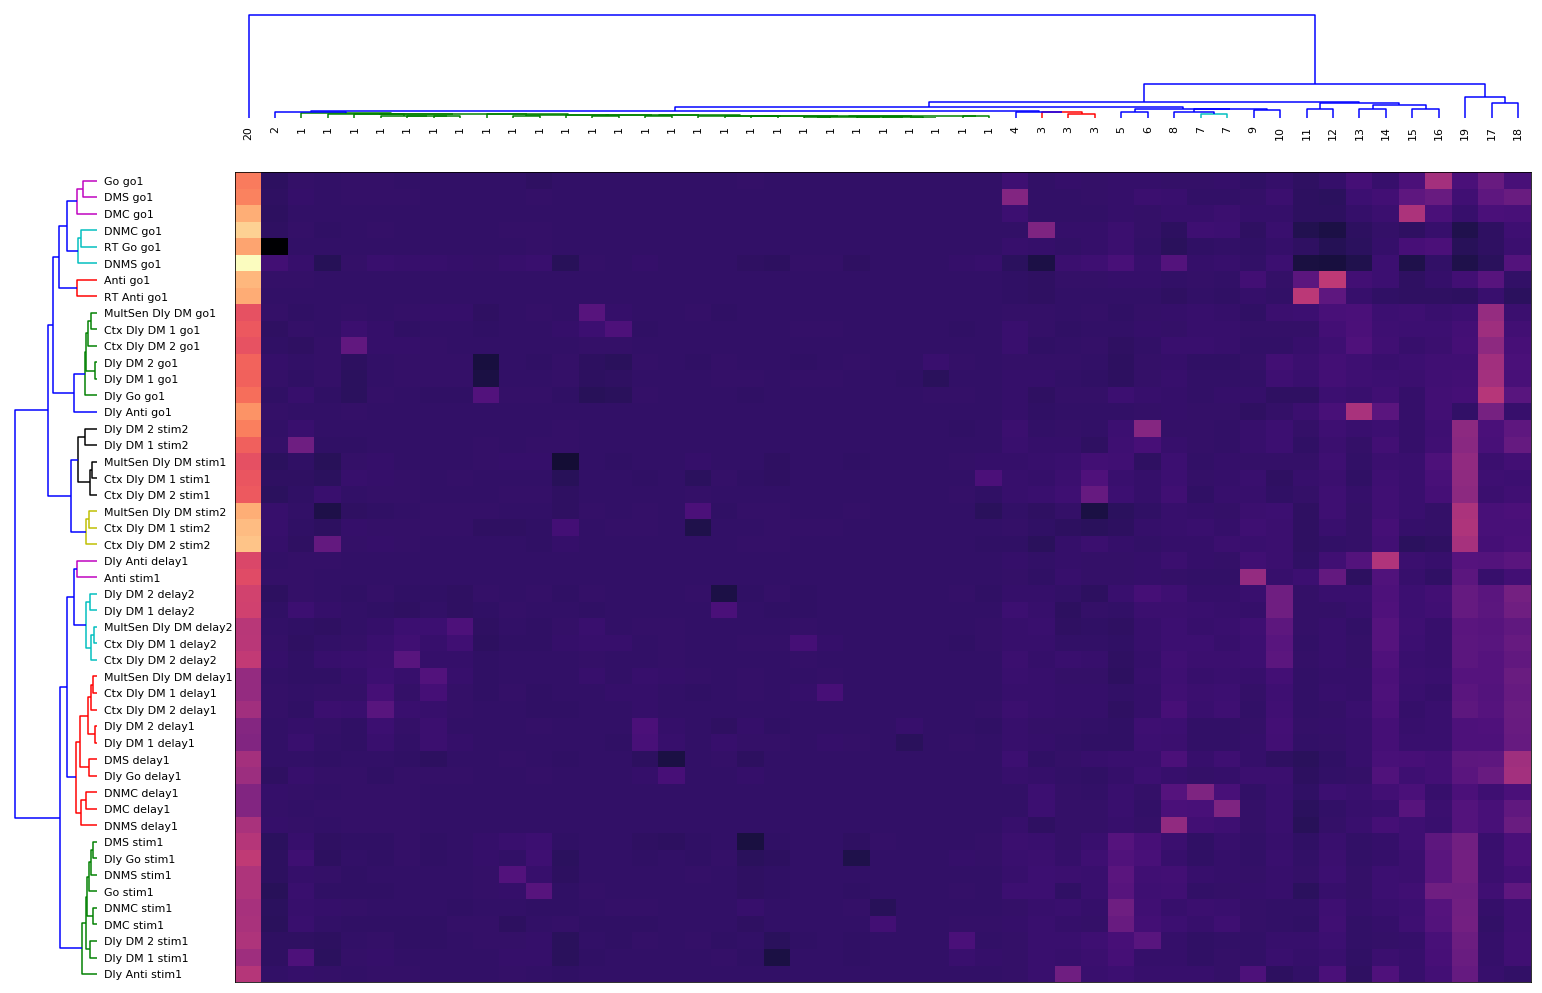

In [82]:
#SAVE new atlas rotated
import scipy
import pylab
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

method = 'ward'
cel_max_d = 3.5
criterion = 'distance'
n_comps = 20

sparse_inds = np.sum(abs(X_v),axis = 0)>1e-3
X_v = X_v[:,sparse_inds]

# Compute and plot dendrogram.
fig = pylab.figure(figsize=(24, 15))
axdendro = fig.add_axes([0.09,0.1,0.05,0.75])
Y = sch.linkage(X_v, method=method)

if criterion == 'maxclust':
    max_d = 14 #max number of task clusters
    clusters = fcluster(Y, max_d, criterion='maxclust') #CHANGE hard coded 14 clusters
else:
    max_d = 5 #threshold for task clusters
    clusters = fcluster(Y, max_d, criterion='distance')

Z = sch.dendrogram(Y, orientation='left',labels = feature_names_master,
                   leaf_font_size = 11,color_threshold=max_d)
axdendro.set_xticks([])
# axdendro.set_yticks([])
axdendro.spines['top'].set_visible(False)
axdendro.spines['right'].set_visible(False)
axdendro.spines['bottom'].set_visible(False)
axdendro.spines['left'].set_visible(False)

# Plot distance matrix.
axmatrix = fig.add_axes([0.22,0.1,0.75,0.75])
index_left = Z['leaves']
tick_names_sorted = [feature_names_master[i] for i in index_left]
X_v = X_v[index_left,:]

# cel_num = [CA.ind_active[x] for x in index_top]
axdendro_top = fig.add_axes([0.22,.9,0.75,0.1])
Y = sch.linkage(X_v.T, method=method)

if criterion== 'maxclust':
    clusters = fcluster(Y, cel_max_d, criterion='maxclust') #CHANGE hard coded 14 clusters
    Z = sch.dendrogram(Y, orientation='top',labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=0)

else:
    clusters = fcluster(Y, cel_max_d, criterion='distance')
    Z = sch.dendrogram(Y, orientation='top',labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=cel_max_d)

axdendro_top.set_yticks([])
axdendro_top.spines['top'].set_visible(False)
axdendro_top.spines['right'].set_visible(False)
axdendro_top.spines['bottom'].set_visible(False)
axdendro_top.spines['left'].set_visible(False)

index_top = Z['leaves']
X_v = X_v[:,index_top]
clusters_sorted = clusters[index_top]
im = axmatrix.matshow(X_v, aspect='auto', origin='lower',cmap='magma')
axmatrix.set_xticks([])
axmatrix.set_yticks([])
# fig.colorbar(im,orientation='horizontal')
plt.show()

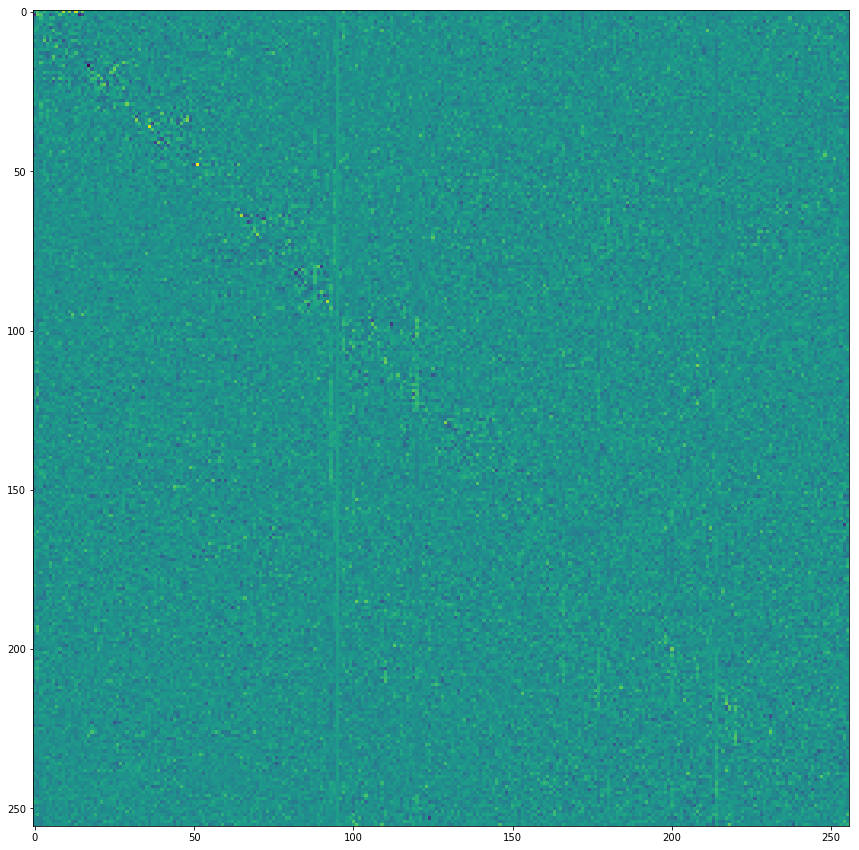

In [83]:
fig = pylab.figure(figsize=(15, 15))
plt.imshow(R)

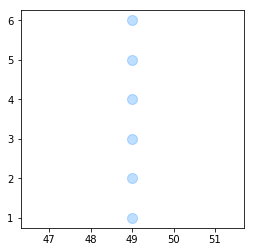

In [93]:
fig = plt.figure(figsize=(4,4))
sparse_ax = plt.subplot(111)

l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 0
lr = -7
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10

rule_trains_set = {}
rule_set_keys = ['all',]
for key in rule_set_keys:
    rule_trains_set[key] = rules_dict[key]
    
x_ind_counter = 0
ax1_xticks = []

for rnn_type in ['GRU', ]: #
    for activation in ['softplus','tanh','retanh']: #
        for init in ['randgauss', 'diag']:# 
            for n_rnn in [256,]:
                
                x_ind_counter+=1
                label = ' '.join([rnn_type,activation,init])
                if len(ax1_xticks)==0:
                    ax1_xticks = [label,]
                else:
                    ax1_xticks.append(label)
                        
                for seed in range(3): #['untrained',]:#['untrained',]:

                    for rule_trains_label in rule_set_keys:
                        rule_trains = rule_trains_set[rule_trains_label]

                        s = '_'
                        rule_trains_str = s.join(rule_trains)

                        net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

                        net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

                        # m = os.path.join(p,'data','rnn','multitask',net,'final',rule_trains_label,rnn_type,activation,
                        #     init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))

                        net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
                        m = os.path.join(p,'data','rnn','multitask',net,'lr',rnn_type,activation,init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,str(seed))

                        lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(cel_max_d)
                        save_dir = os.path.join(m,lesion_folder)
                        varimax_var = np.load(os.path.join(save_dir,'rotate_D_var.npz'))
                        
                        X_v = varimax_var['D_rotated']
                        sparse_inds = np.sum(abs(X_v),axis = 0)>1e-3
                        sparse_ax.plot(np.sum(sparse_inds),x_ind_counter,'o',alpha = .1,c = 'dodgerblue', markersize = 10)


In [89]:
varimax_var.keys()

['R', 'D_rotated', 'feature_names_master', 'D', 'components_set']